In [101]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [102]:
class Graph:
    def __init__(self, num_nodes, positions):
        self.num_nodes = num_nodes
        self.positions = positions

    def get_distance(self, u, v):
        x1, y1 = self.positions[u]
        x2, y2 = self.positions[v]
        return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def get_all_pairs_distances(self):
        dist_matrix = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                dist = self.get_distance(i, j)
                dist_matrix[i][j] = dist_matrix[j][i] = dist

        return dist_matrix

## Brute-Force Algorithm
The brute-force algorithm considers all possible combinations of `k` centers in the graph. 
It calculates the radius for each combination and selects the one with the smallest maximum radius. 
While it guarantees the optimal solution, it has a high computational cost, making it impractical for large graphs.

In [103]:
def brute_force_k_center(graph, k):
    dist_matrix = graph.get_all_pairs_distances()
    best_centers = None
    min_radius = float('inf')

    for centers in itertools.combinations(range(graph.num_nodes), k):
        
        max_distance = 0
        for node in range(graph.num_nodes):
            min_distance_to_center = min(dist_matrix[node][center] for center in centers)
            max_distance = max(max_distance, min_distance_to_center)

        # Apdejtuje najbolji centar
        if max_distance < min_radius:
            min_radius = max_distance
            best_centers = centers

    return best_centers, min_radius

## Greedy Algorithm
The greedy algorithm iteratively selects the next center to maximize the minimum distance to the closest existing center. 
While faster than brute force, it does not guarantee the optimal solution. It's a heuristic approach that often provides reasonably good results.

In [104]:
def greedy_k_center(graph, k):
    dist_matrix = graph.get_all_pairs_distances()
    centers = []
    remaining_nodes = set(range(graph.num_nodes))

    # Bira random centar
    centers.append(remaining_nodes.pop())
    
    while len(centers) < k:
        max_min_dist = -1
        next_center = None
        for node in remaining_nodes:
            min_dist_to_center = min(dist_matrix[node][center] for center in centers)
            if min_dist_to_center > max_min_dist:
                max_min_dist = min_dist_to_center
                next_center = node

        centers.append(next_center)
        remaining_nodes.remove(next_center)

    radius = 0
    for node in range(graph.num_nodes):
        min_distance_to_center = min(dist_matrix[node][center] for center in centers)
        radius = max(radius, min_distance_to_center)

    return centers, radius

## Local Search Algorithm
Local search starts with an initial solution (e.g., from the greedy algorithm) and iteratively improves it by replacing centers. 
The goal is to minimize the radius. It stops when no further improvement is possible. This approach balances computational effort and result quality.

In [105]:
def compute_radius(graph, centers, dist_matrix):
    
    radius = 0
    
    for node in range(graph.num_nodes):
        min_distance_to_center = min(dist_matrix[node][center] for center in centers)
        radius = max(radius, min_distance_to_center)

    return radius

def local_search_k_center(graph, k, initial_centers=None):
    dist_matrix = graph.get_all_pairs_distances()

    # Initialize centers using greedy algorithm if not provided
    if initial_centers is None:
        initial_centers, _ = greedy_k_center(graph, k)

    current_centers = list(initial_centers)
    improved = True

    while improved:
        improved = False
        current_radius = compute_radius(graph, current_centers, dist_matrix)

        for i, old_center in enumerate(current_centers):
            for node in range(graph.num_nodes):
                if node in current_centers:
                    continue

                # Replace one center with a new node
                new_centers = current_centers[:]
                new_centers[i] = node

                # Calculate new radius
                new_radius = compute_radius(graph, new_centers, dist_matrix)

                # Update if new radius is better
                if new_radius < current_radius:
                    current_centers = new_centers
                    current_radius = new_radius
                    improved = True

    return current_centers, current_radius

## Genetic Algorithm
This metaheuristic uses a population of solutions, evolves them over generations, and applies selection, crossover, and mutation. 
The goal is to minimize the radius. While it does not guarantee the optimal solution, it is effective for large and complex graphs.

In [106]:
def genetic_k_center(graph, k, population_size=50, generations=100, mutation_rate=0.1):
    dist_matrix = graph.get_all_pairs_distances()

    def fitness(individual):
        radius = 0
        for node in range(graph.num_nodes):
            min_distance_to_center = min(dist_matrix[node][center] for center in individual)
            radius = max(radius, min_distance_to_center)
        return radius

    def create_individual():
        return random.sample(range(graph.num_nodes), k)

    def mutate(individual):
        if random.random() < mutation_rate:
            idx_to_replace = random.randint(0, k - 1)
            new_node = random.choice([node for node in range(graph.num_nodes) if node not in individual])
            individual[idx_to_replace] = new_node

    def crossover(parent1, parent2):
        split = random.randint(1, k - 1)
        child = parent1[:split] + [node for node in parent2 if node not in parent1[:split]]
        return child[:k]

    # Initialize population
    population = [create_individual() for _ in range(population_size)]

    for _ in range(generations):
        population.sort(key=fitness)
        next_generation = population[:population_size // 2]

        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(population[:population_size // 2], 2)
            child = crossover(parent1, parent2)
            mutate(child)
            next_generation.append(child)

        population = next_generation

    best_individual = min(population, key=fitness)
    best_radius = fitness(best_individual)

    return best_individual, best_radius

## K-Means Heuristic
This algorithm starts with random centers and iteratively refines them by grouping nodes into clusters based on proximity. 
It recalculates centers based on the cluster's mean position. It's fast and effective but does not guarantee an optimal solution.

In [107]:

def k_means_heuristic(graph, k, iterations=100):
    centers = random.sample(range(graph.num_nodes), k)
    dist_matrix = graph.get_all_pairs_distances()

    for _ in range(iterations):
        clusters = {center: [] for center in centers}

        for node in range(graph.num_nodes):
            closest_center = min(centers, key=lambda center: dist_matrix[node][center])
            clusters[closest_center].append(node)

        new_centers = []
        for center, nodes in clusters.items():
            if nodes:
                avg_x = sum(graph.positions[node][0] for node in nodes) / len(nodes)
                avg_y = sum(graph.positions[node][1] for node in nodes) / len(nodes)
                closest_node = min(nodes, key=lambda node: np.sqrt((graph.positions[node][0] - avg_x)**2 + (graph.positions[node][1] - avg_y)**2))
                new_centers.append(closest_node)

        if set(new_centers) == set(centers):
            break

        centers = new_centers

    return centers, compute_radius(graph, centers, dist_matrix)

## Simulated Annealing Algorithm
Simulated annealing explores the solution space by introducing random variations. 
It accepts worse solutions with a probability depending on the current temperature, allowing it to escape local minima. 
The temperature decreases over time until the algorithm converges.

In [108]:
def simulated_annealing_k_center(graph, k, initial_temp=1000, cooling_rate=0.995, min_temp=1e-4):

    dist_matrix = graph.get_all_pairs_distances()  # Get the distance matrix

    # Randomly initialize the centers
    centers = random.sample(range(graph.num_nodes), k)
    current_radius = compute_radius(graph, centers, dist_matrix)  # Compute the initial radius using the distance matrix
    best_centers = list(centers)
    best_radius = current_radius

    temp = initial_temp

    while temp > min_temp:
        # Generate a neighboring solution by swapping a center
        new_centers = centers[:]
        i = random.randint(0, k - 1)
        new_node = random.choice([node for node in range(graph.num_nodes) if node not in new_centers])
        new_centers[i] = new_node

        # Compute the radius of the new solution
        new_radius = compute_radius(graph, new_centers, dist_matrix)  # Compute the radius using the distance matrix

        # Accept the new solution if it's better or with some probability if it's worse
        if new_radius < current_radius or random.random() < math.exp((current_radius - new_radius) / temp):
            centers = new_centers
            current_radius = new_radius

            # Update the best solution
            if current_radius < best_radius:
                best_centers = centers
                best_radius = current_radius

        # Decrease the temperature
        temp *= cooling_rate

    return best_centers, best_radius

## Ant Colony Optimization Algorithm
Ant colony optimization mimics the behavior of ants finding paths to food. 
Ants deposit pheromones on paths, influencing the probability of future ants selecting those paths. 
The algorithm iteratively reinforces paths leading to good solutions and evaporates weaker paths.

In [109]:
def ant_colony_k_center(graph, k, num_ants=10, iterations=50, evaporation_rate=0.7, pheromone_boost=3.0):
    dist_matrix = graph.get_all_pairs_distances()

    # Initialize pheromone matrix
    pheromone = np.ones((graph.num_nodes, graph.num_nodes))

    def choose_centers():
        centers = set()
        probabilities = pheromone.sum(axis=0)
        probabilities /= probabilities.sum()
        while len(centers) < k:
            chosen = np.random.choice(range(graph.num_nodes), p=probabilities)
            centers.add(chosen)
        return list(centers)

    def update_pheromone(centers, radius):
        for i in centers:
            for j in range(graph.num_nodes):
                pheromone[i][j] += pheromone_boost / radius

    best_centers = None
    best_radius = float('inf')

    for _ in range(iterations):
        for _ in range(num_ants):
            centers = choose_centers()
            radius = compute_radius(graph, centers, dist_matrix)

            if radius < best_radius:
                best_radius = radius
                best_centers = centers

            update_pheromone(centers, radius)

        # Evaporation
        pheromone *= (1 - evaporation_rate)

    return best_centers, best_radius


In [110]:
#results = []
#for num_ants in [10, 20, 30]:
#    for iterations in [50, 100, 200]:
#        for evaporation_rate in [0.3, 0.5, 0.7]:
#            for pheromone_boost in [1.0, 2.0, 3.0]:
#                centers, radius = ant_colony_k_center(
#                    graph, k, num_ants, iterations, evaporation_rate, pheromone_boost
#                )
#                results.append((num_ants, iterations, evaporation_rate, pheromone_boost, radius))
                
# Find the best configuration
#best_config = min(results, key=lambda x: x[-1])
#print("Best Parameters:", best_config)


In [111]:
def visualize_graph(graph, centers, radius, title, color):
    pos = graph.positions
    x, y = zip(*pos)

    # Move overlapping nodes slightly apart
    def adjust_positions(positions, threshold=0.5):
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                xi, yi = positions[i]
                xj, yj = positions[j]
                dist = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2)
                if dist < threshold:  # If nodes are too close, move them apart
                    offset = threshold - dist
                    angle = np.arctan2(yj - yi, xj - xi)
                    # Move nodes away from each other along the line connecting them
                    positions[i] = (xi - offset * np.cos(angle), yi - offset * np.sin(angle))
                    positions[j] = (xj + offset * np.cos(angle), yj + offset * np.sin(angle))

    adjusted_positions = pos.copy()
    adjust_positions(adjusted_positions)
    x, y = zip(*adjusted_positions)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(x, y, s=100, c='lightblue', label="Nodes", edgecolors='black', zorder=5)

    # Annotate nodes
    for i, (xi, yi) in enumerate(adjusted_positions):
        ax.text(xi, yi, str(i), fontsize=8, ha='center', va='center', zorder=10)

    # Draw circles for each center
    for center in centers:
        xi, yi = adjusted_positions[center]
        circle = plt.Circle((xi, yi), radius, color=color, fill=True, alpha=0.2, linewidth=2)
        ax.add_artist(circle)

    # Add radius label behind the plot
    fig.text(
        0.5, 0.95, f"Radius: {radius:.2f}",
        fontsize=14, color='darkred', alpha=0.7,
        ha='center', va='center'
    )

    # Add title to the plot
    ax.set_title(title, fontsize=14, pad=20)

    ax.set_aspect('equal')
    plt.show()


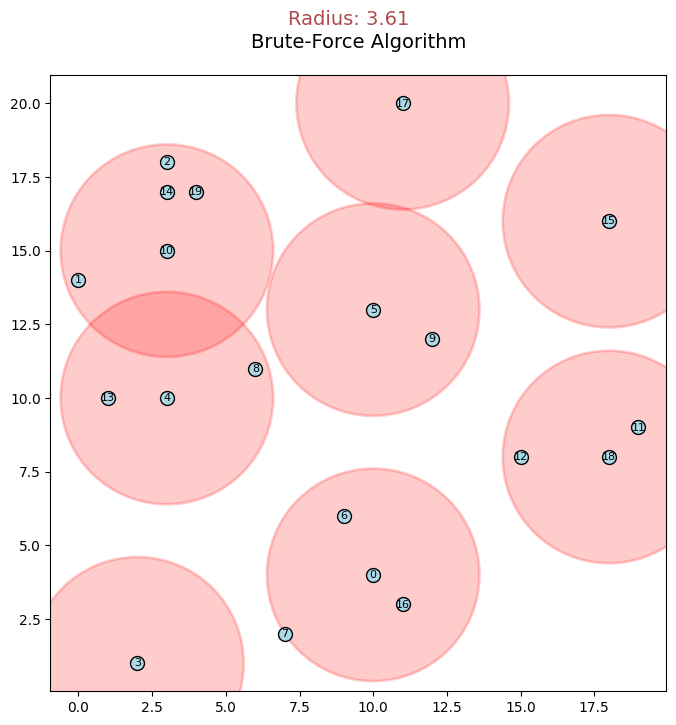

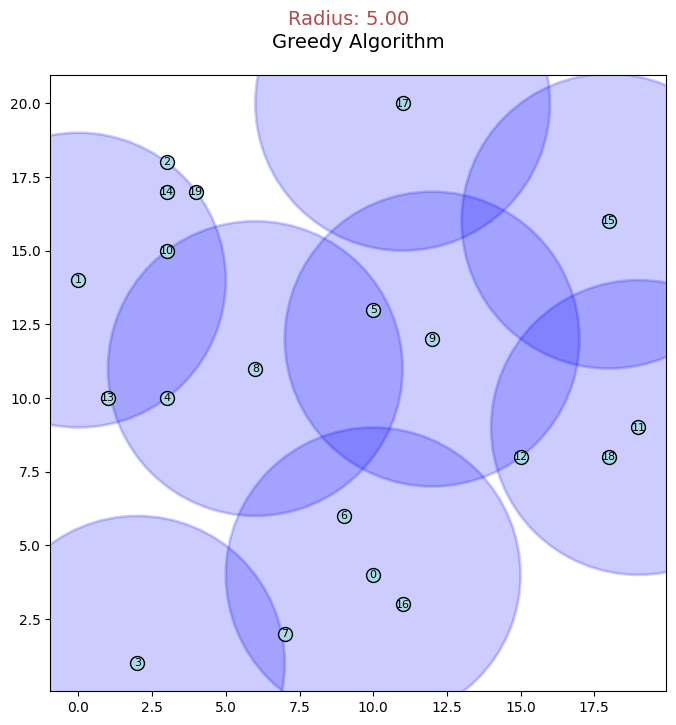

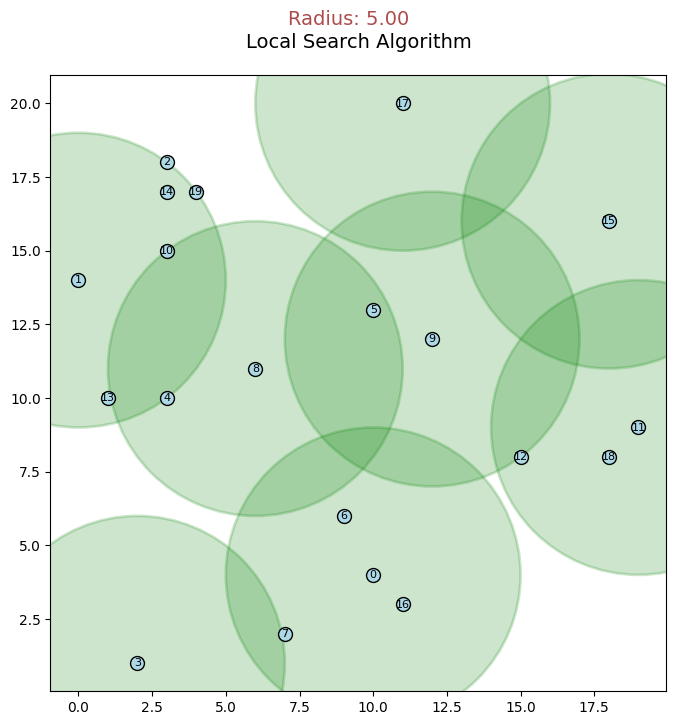

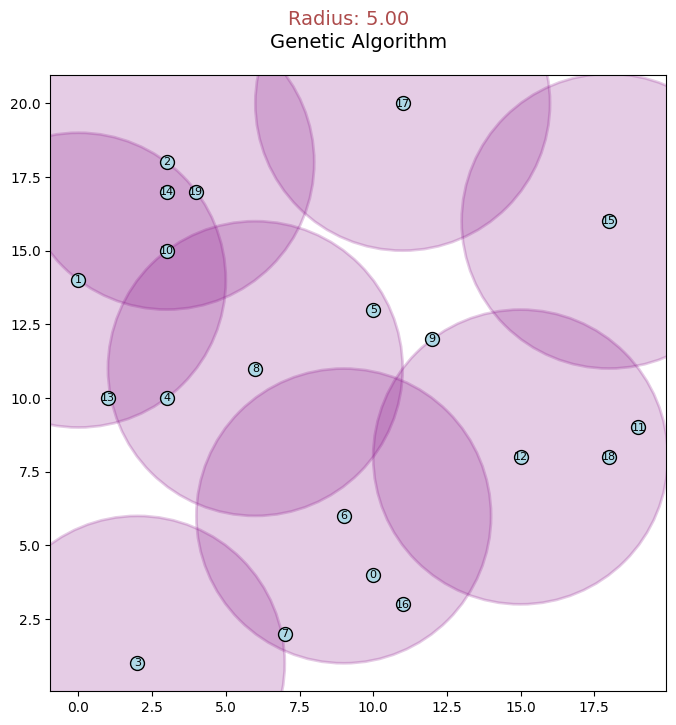

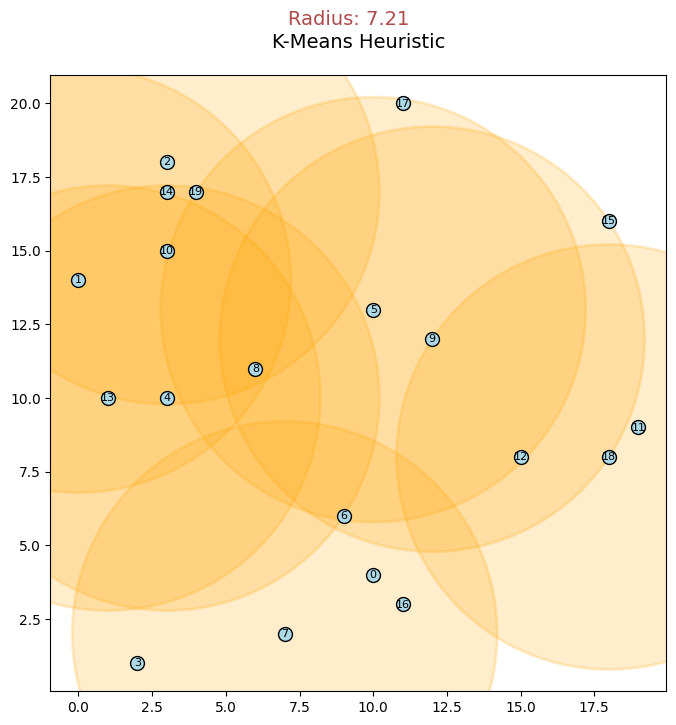

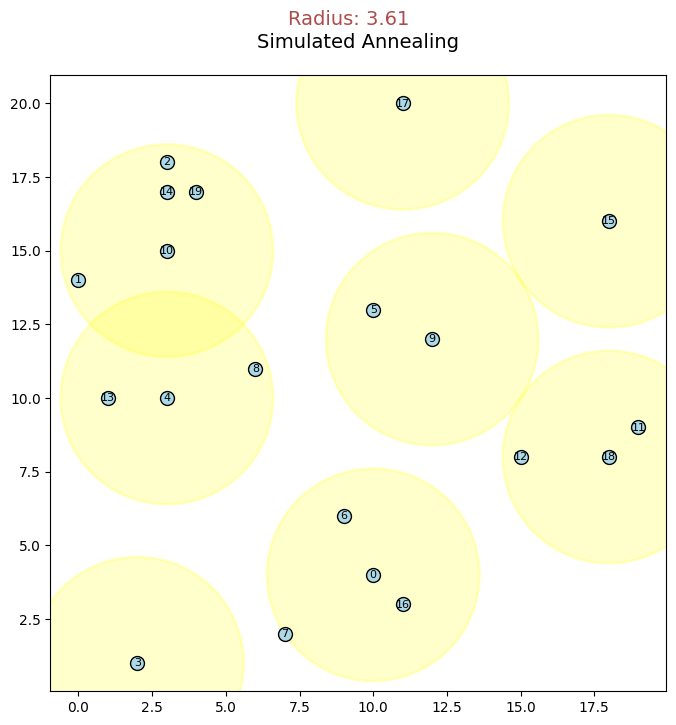

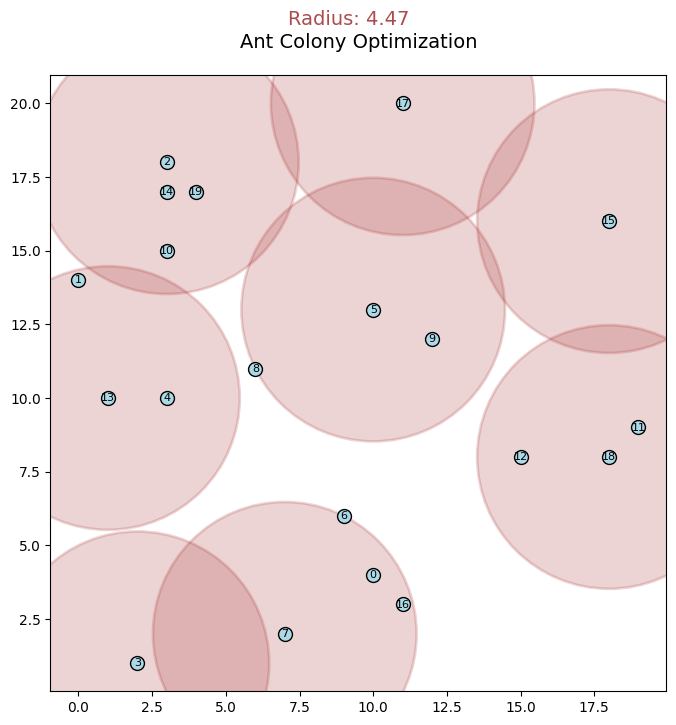

In [112]:

# Generate 20 random positions with coordinates in a specified range (e.g., 0 to 20)
positions = [(random.randint(0, 20), random.randint(0, 20)) for _ in range(20)]

graph = Graph(20, positions)
k = 8  # 8 centers

#positions = [(1, 2), (2, 3), (3, 4), (5, 5), (8, 1), (7, 2), (10, 5), (6, 8), (9, 6), (4, 4), (12, 9), (14, 7), (13, 3), (11, 6), (15, 8)]

#graph = Graph(15, positions)
#k = 6  # 6 centers

# Brute-force algorithm
bf_centers, bf_radius = brute_force_k_center(graph, k)
visualize_graph(graph, bf_centers, bf_radius, "Brute-Force Algorithm", "red")

# Greedy algorithm
gr_centers, gr_radius = greedy_k_center(graph, k)
visualize_graph(graph, gr_centers, gr_radius, "Greedy Algorithm", "blue")

# Local search algorithm
ls_centers, ls_radius = local_search_k_center(graph, k)
visualize_graph(graph, ls_centers, ls_radius, "Local Search Algorithm", "green")

# Genetic algorithm
ga_centers, ga_radius = genetic_k_center(graph, k)
visualize_graph(graph, ga_centers, ga_radius, "Genetic Algorithm", "purple")

# K-Means heuristic
km_centers, km_radius = k_means_heuristic(graph, k)
visualize_graph(graph, km_centers, km_radius, "K-Means Heuristic", "orange")

# Simulated Annealing algorithm
sa_centers, sa_radius = simulated_annealing_k_center(graph, k)
visualize_graph(graph, sa_centers, sa_radius, "Simulated Annealing", "yellow")

# Ant Colony Optimization Algorithm
aco_centers, aco_radius = ant_colony_k_center(graph, k)
visualize_graph(graph, aco_centers, aco_radius, "Ant Colony Optimization", "brown")

